# Estimating Extreme Risks and Dependence of Stock Indices
#### Research Project for the Course Quantitative Risk Management
Authors: **Nicolo Giacopelli & Oskar Girardin**

## I – Empirical/descriptive analysis

In [7]:
# Import libraries
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from scipy.stats import norm, kurtosis, skew
from itertools import combinations
from collections import defaultdict
import matplotlib.ticker as mtick
from statsmodels.distributions.copula.api import StudentTCopula
import pycopula

# Define colors of graphs
DARK_COL = "#138086"
LIGHT_COL = "#f0b64d"
sns.set_style("whitegrid")

ALL_COL = ["#c1272d", "#0000a7", "#008176", "#b3b3b3"]


In [8]:
# Download data from 1987 to end of 2022
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2022, 12, 31)
tickers_indeces = ["^GSPC", "^FTSE", "^GDAXI"]

data = yf.download(tickers_indeces, start = start, end = end, progress=False)
prices = data["Adj Close"]

# Rename columns
prices = prices.rename({"^GSPC": "SP500", "^GDAXI": "DAX", "^FTSE": "FTSE"}, axis = 1)

prices


,FTSE,DAX,SP500
Date,,,
1987-01-02,1681.099976,NaN,246.449997
1987-01-05,1680.000000,NaN,252.190002
1987-01-06,1690.699951,NaN,252.779999
1987-01-07,1722.199951,NaN,255.330002
1987-01-08,1733.099976,NaN,257.279999
...,...,...,...
2022-12-23,7473.000000,13940.929688,3844.820068
2022-12-27,NaN,13995.099609,3829.250000
2022-12-28,7497.200195,13925.599609,3783.219971


### 1. Show the plot of the daily prices, $p_i$ of the S&P 500, then describe what you see

In [9]:

def plot_time_series(df, col_name, ylab = 'Price (in US $)', title = None, xlab = "Date", perc=False):
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(df.index, df[col_name], color = DARK_COL)

    # Set the axis labels and title
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.set_title(title, fontsize=20, y=1.02)
    ax.grid(False)
    if perc:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    
    # Tick size
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    
    # Show the plot
    plt.show()



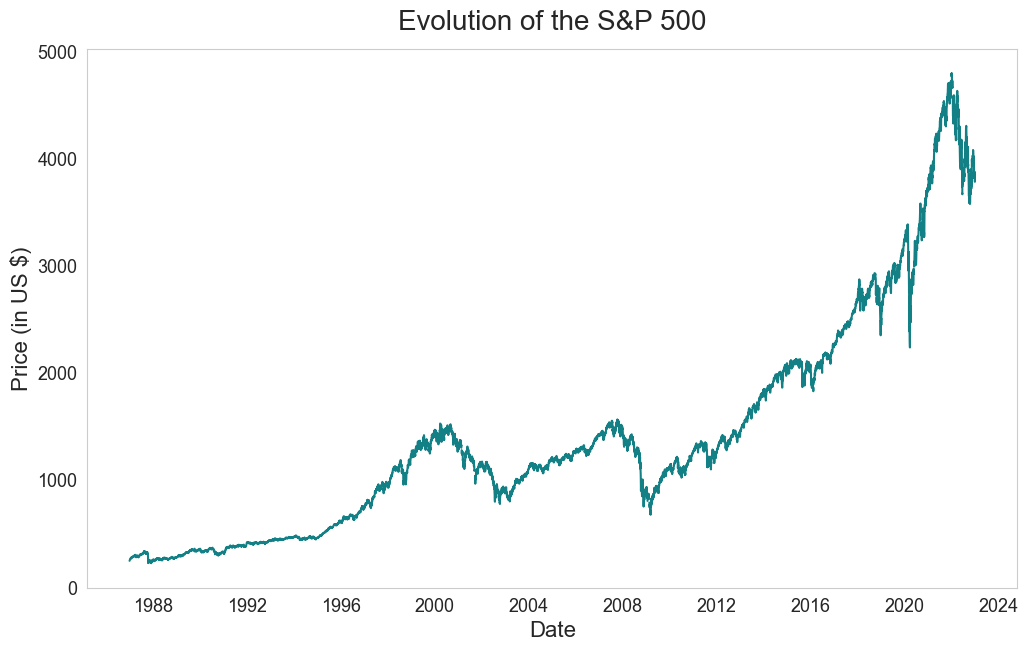

In [10]:

plot_time_series(prices, "SP500", title="Evolution of the S&P 500")


### 2. Transform your three data sets to consider now the daily log return: $$x_i = \log p_i - \log p_{i-1}$$ and give a plot of this new data set (x_i, i = 1,...,n) for the S&P 500. What do you notice? Why did we perform this transformation? We consider the obtained returns as realization of three random variables (rv)’s: $U$ the rv for the S&P 500 returns, $V$ the rv for the FTSE returns, and $W$ the rv for the DAX.

In [11]:
# Download data from 1987 to end of 2022 (separately for each)

start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2022, 12, 31)

FTSE = yf.download(["^FTSE"], start = start, end = end, progress=False)
DAX = yf.download(["^GDAXI"], start = start, end = end, progress=False)
SP500 = yf.download(["^GSPC"], start = start, end = end, progress=False)


# Log returns

FTSE_logreturn = np.log(FTSE["Adj Close"]).diff(periods=1)*100
DAX_logreturn = np.log(DAX["Adj Close"]).diff(periods=1)*100
SP500_logreturn = np.log(SP500["Adj Close"]).diff(periods=1)*100


# Merge in full dataset 

all_dates = prices.index
logreturns = pd.DataFrame(columns=[], index=all_dates)
logreturns = pd.merge(logreturns, SP500_logreturn, how="left", on="Date")
logreturns = pd.merge(logreturns, FTSE_logreturn, how="left", on="Date")
logreturns = pd.merge(logreturns, DAX_logreturn, how="left", on="Date")
logreturns.columns = ["SP500", "FTSE", "DAX"]


# Losses (not syncronized)

loglosses = - logreturns.copy()

logreturns



,SP500,FTSE,DAX
Date,,,
1987-01-02,NaN,NaN,NaN
1987-01-05,2.302366,-0.065453,NaN
1987-01-06,0.233676,0.634882,NaN
1987-01-07,1.003729,1.845990,NaN
1987-01-08,0.760815,0.630918,NaN
...,...,...,...
2022-12-23,0.585095,0.049526,0.192851
2022-12-27,-0.405784,NaN,0.387815
2022-12-28,-1.209347,0.323312,-0.497840


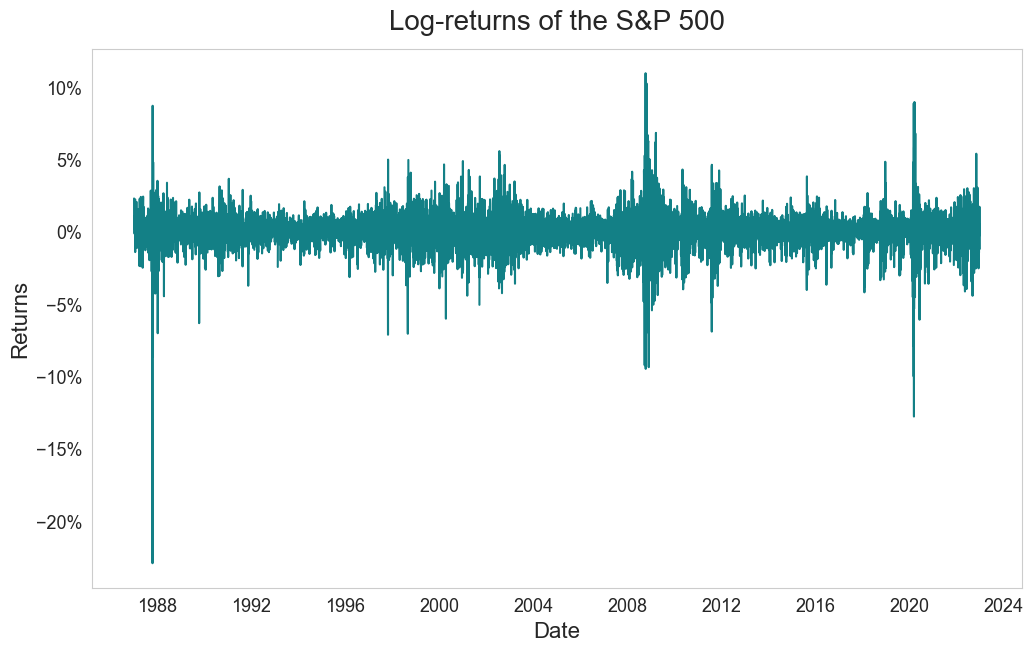

In [12]:

plot_time_series(logreturns, "SP500", ylab="Returns", title= "Log-returns of the S&P 500", perc=True)


### 3. Present your empirical analysis done on these later data sets in two tables, one for the basic statistics containing: 
1. Descriptive statistics (number of observations, $\mu$, $\sigma$, skewness, kurtosis) 
2. Rank statistics (Maximum, Median, Minimum)

In [13]:
def compute_stats(df):
    moment_functions = ["count", "mean", "std", "skew", "kurt", "min", "median", "max"]
    return df.agg(moment_functions, axis=0)

In [14]:
basic_stats = compute_stats(logreturns)
basic_stats

,SP500,FTSE,DAX
count,9072.000000,9091.000000,8846.000000
mean,0.030268,0.016379,0.029713
std,1.182399,1.116227,1.402100
skew,-1.184997,-0.561723,-0.293025
kurt,25.137566,10.225938,6.647321
min,-22.899729,-13.028599,-14.091166
median,0.059354,0.052016,0.079373
max,10.957197,9.384244,10.797468


In [15]:
def get_risk_measure(df, method, alpha):
    # df is dataframe of Losses
    
    res = {}
    for stock_index in df.columns:
        stock_series = df[stock_index].copy()
        if method == "VaR":
            value = np.nanquantile(stock_series, q = alpha)
        elif method == "tVaR":
            value = stock_series[stock_series > np.nanquantile(stock_series, q = alpha)].mean(axis=0)
        else:
            print(f"Error in the method")
            value = -1
        res[stock_index] = value
    res = pd.Series(res)
    return res


In [16]:

alpha_var = 0.995
alpha_tvar = 0.99


# Get VAR at 99.5%
VAR = get_risk_measure(loglosses, "VaR", alpha_var)
# Get tVAR at 99%
tVAR = get_risk_measure(loglosses, "tVaR", alpha_tvar)


# Get VAR and tVAR using gaussian model
gauss = norm(loc=0, scale=1)

# Mean and Std of Losses (!!!! we cannot use the same mean as before since now we are using the LOSSES !!!!)
moments = ["mean", "std"]
losses_stats = loglosses.agg(moments, axis=0)
means = losses_stats.loc["mean", :]
stds = losses_stats.loc["std", :]

VAR_gaussian = means + stds*gauss.ppf(alpha_var)  # inverse of cdf
tVAR_gaussian = means + stds*(gauss.pdf(gauss.ppf(alpha_tvar)))/(1-alpha_tvar) 


# Combine into one dataframe
risk_measures = pd.DataFrame([VAR, VAR_gaussian, tVAR, tVAR_gaussian], index = ["VAR_empirical", "VAR_gaussian", 
                                                                                "tVAR_empirical", "tVAR_gaussian"])
risk_measures


,SP500,FTSE,DAX
VAR_empirical,4.253311,3.899305,5.080003
VAR_gaussian,3.015391,2.858830,3.581857
tVAR_empirical,5.039101,4.532371,5.450954
tVAR_gaussian,3.121079,2.958604,3.707184


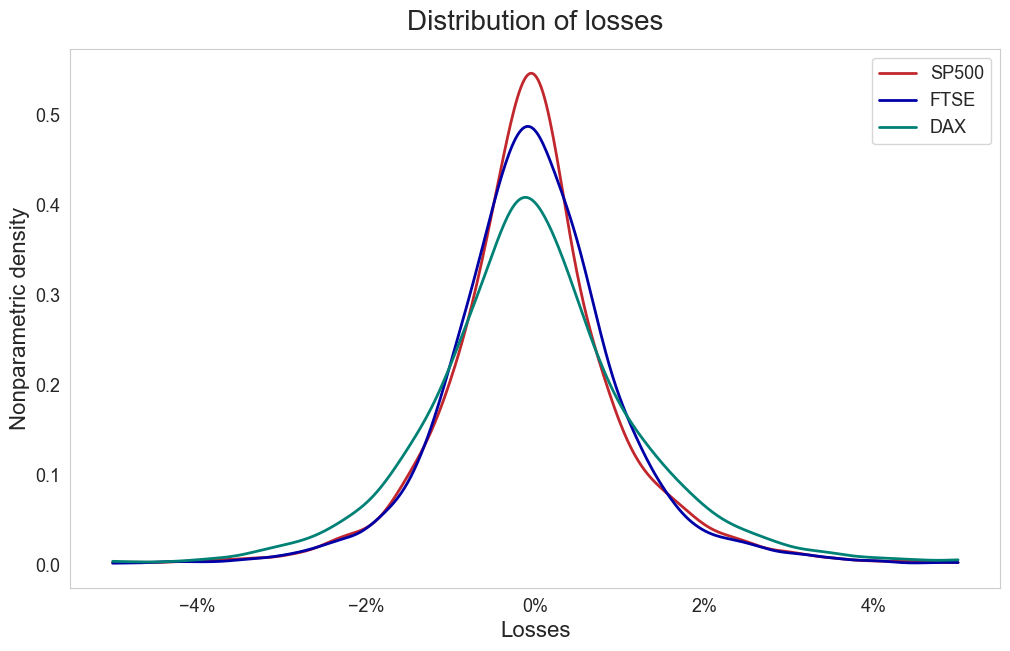

In [17]:
# Create the plot

fig, ax = plt.subplots(figsize=(12, 7))

for i in range(3):
    values = loglosses.iloc[:,i].dropna().copy()
    d = stats.gaussian_kde(values)
    ind = np.linspace(-5, 5, 500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, kdepdf, label=loglosses.columns[i], linewidth=2, color=ALL_COL[i])

# Set the axis labels and title
plt.xlabel("Losses", fontsize=16)
plt.ylabel("Nonparametric density", fontsize=16, x=-0.8)
plt.title("Distribution of losses", fontsize=20, y=1.02)
plt.legend(fontsize=13)

# Ticks
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.grid(False)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
    
    
# Show the plot
plt.show()


### e. Build a portfolio, $Z = U + V + W$, with the three indices and compute the empirical VaR of the losses at 99.5% and the TVaR at 99%. Allocate the capital according to: $C(L|P) = \mathbb{E}[L] - \mathbb{E}[L|Z \leq F_Z^{-1}(\alpha)]$, to the three indices in the portfolio.

In [18]:
# Alignment, Losses and Portfolio

returns = logreturns.dropna(axis=0).copy()
returns["Z"] = returns[["SP500", "FTSE", "DAX"]].sum(axis=1)

losses = - returns.copy()

assert losses.isna().sum().sum() == 0, "check"

losses


,SP500,FTSE,DAX,Z
Date,,,,
1988-01-05,-1.045544,-4.322063,-4.057731,-9.425337
1988-01-06,-0.100483,0.139794,-0.989967,-0.950656
1988-01-07,-0.838528,-0.005594,-0.837426,-1.681548
1988-01-08,7.008244,0.775150,-1.197370,6.586024
1988-01-11,-1.666404,0.747121,3.889849,2.970565
...,...,...,...,...
2022-12-22,1.455714,0.374167,1.311962,3.141843
2022-12-23,-0.585095,-0.049526,-0.192851,-0.827473
2022-12-28,1.209347,-0.323312,0.497840,1.383875


In [19]:
# Compute risk measures for Z
alpha_var = 0.995
alpha_tvar = 0.99


# Get VAR at 99.5%
VAR = get_risk_measure(losses, "VaR", alpha_var)
# Get tVAR at 99%
tVAR = get_risk_measure(losses, "tVaR", alpha_tvar)


# Combine into one dataframe
risk_measures = pd.DataFrame([VAR, tVAR], index = ["VAR_empirical", "tVAR_empirical"])
risk_measures


,SP500,FTSE,DAX,Z
VAR_empirical,4.144687,3.709643,5.053964,11.467759
tVAR_empirical,4.759571,4.220542,5.349617,12.673033


In [20]:

# Capital Allocation (USING TVAR!!!)

def get_capital_allocation(df, alpha):
    # df is dataframe of Losses
    indexes = df["Z"] >= np.quantile(df["Z"], q = alpha)
    losses_subset = df[["FTSE", "DAX", "SP500"]].copy()
    allocations = {}
    
    for stock_index in losses_subset.columns:
        # full series
        stock_series = losses_subset[stock_index]
        # conditional in time of crisis (positive, since losses)
        conditional_mean = stock_series[indexes].mean()
        # unconditional  (negative, since losses)
        unconditional_mean = stock_series.mean()
        # result
        tasche = -unconditional_mean + conditional_mean
        # store
        allocations[stock_index] = tasche
        
    res = pd.DataFrame(list(allocations.values()), index=list(allocations.keys()), columns=["Euler"])
    return res

# We use TVAR due to how Capital Allocation definition is given (based on TVar)
capital_allocation = get_capital_allocation(losses, alpha_tvar)
capital_allocation



,Euler
FTSE,3.925484
DAX,4.981664
SP500,3.828581


In [21]:
def get_diversification_benefits(df, alpha, df_allocations): 
    # df is dataframe of Losses
    df_allocations["Div_Ben_%"] = 0
    
    losses_subset = df[["FTSE", "DAX", "SP500"]].copy()
    
    for stock_index in losses_subset.columns:
        # full series
        stock_series = losses_subset[stock_index]
        # indexes of times of crisis
        indexes = stock_series >= np.quantile(stock_series, q = alpha)
        # conditional mean in time of crisis (positive)
        conditional_mean = stock_series[indexes].mean()
        # unconditional  (negative)
        unconditional_mean = stock_series.mean()
        # denominator
        tasche_alone = -unconditional_mean + conditional_mean
        # result
        res = 1 - (df_allocations.loc[stock_index, "Euler"] / tasche_alone)
        df_allocations.loc[stock_index, "Div_Ben_%"] = res*100
        
    return df_allocations
        
        
# Always alpha for TVar

capital_benefits = get_diversification_benefits(losses, alpha_tvar, capital_allocation)
capital_benefits    
    
    

,Euler,Div_Ben_%
FTSE,3.925484,7.245903
DAX,4.981664,7.248749
SP500,3.828581,20.059569


In [22]:
# Mean of losses
losses.mean(axis = 0)

SP500   -0.029721
FTSE    -0.011599
DAX     -0.021376
Z       -0.062696
dtype: float64

### e. RoRAC

In [23]:
n_business_days = 252

year_returns = returns.mean(axis=0)*n_business_days
year_var = risk_measures.T["VAR_empirical"]*np.sqrt(n_business_days)
year_tvar = risk_measures.T["tVAR_empirical"]*np.sqrt(n_business_days)

# Check all indexes are the same
assert ((year_returns.index == year_var.index).all() and (year_returns.index == year_tvar.index).all()), "check"

rorac_df = pd.DataFrame({"returns_year": year_returns.tolist(),
              "var_year": year_var.tolist(),
              "tvar_year": year_tvar.tolist()}, index=year_returns.index)

rorac_df

,returns_year,var_year,tvar_year
SP500,7.489762,65.794859,75.555854
FTSE,2.922880,58.888761,66.999029
DAX,5.386849,80.229195,84.922543
Z,15.799491,182.045037,201.178159


In [24]:
rorac_df["RoRAC_Var"] = rorac_df["returns_year"]/rorac_df["var_year"]         
rorac_df["RoRAC_tVar"] = rorac_df["returns_year"]/rorac_df["tvar_year"]      
rorac_df

,returns_year,var_year,tvar_year,RoRAC_Var,RoRAC_tVar
SP500,7.489762,65.794859,75.555854,0.113835,0.099129
FTSE,2.922880,58.888761,66.999029,0.049634,0.043626
DAX,5.386849,80.229195,84.922543,0.067143,0.063432
Z,15.799491,182.045037,201.178159,0.086789,0.078535


In [65]:
# RoRAC indeces in portfolio based on capital allocated looking at ES of portfolio

rorac_entire_var = rorac_df.loc[["SP500", "FTSE", "DAX"], ["returns_year"]].copy() / rorac_df.loc["Z", "var_year"].copy()
rorac_df["RoRAC_f_Var"] = rorac_entire_var.values.ravel().tolist() + [""]
rorac_df["RoRAC_f_Var"] = rorac_df["RoRAC_f_Var"]/capital_benefits.loc[["SP500", "FTSE", "DAX"], "Euler"]*risk_measures.loc["VAR_empirical", "Z"]

rorac_entire_tvar = rorac_df.loc[["SP500", "FTSE", "DAX"], ["returns_year"]].copy() / rorac_df.loc["Z", "tvar_year"].copy()# * capital_benefits.loc[["SP500", "FTSE", "DAX"], "Euler"]/rorac_df.loc["Z", "tvar_year"].copy()
rorac_df["RoRAC_f_tVar"] = rorac_entire_tvar.values.ravel().tolist() + [""]
rorac_df["RoRAC_f_tVar"] = rorac_df["RoRAC_f_Var"]/capital_benefits.loc[["SP500", "FTSE", "DAX"], "Euler"]*risk_measures.loc["tVAR_empirical", "Z"]

rorac_df.iloc[:,3:]*100


,RoRAC_Var,RoRAC_tVar,RoRAC_f_Var,RoRAC_f_tVar
SP500,11.383507,9.912882,12.323382,40.791774
FTSE,4.963392,4.362571,4.690482,15.142753
DAX,6.714325,6.343250,6.811772,17.32871
Z,8.678891,7.853482,NaN,NaN


## II. EVT model on the losses

## Block Maxima

In [26]:
# We consider month frequency   (https://lup.lub.lu.se/luur/download?func=downloadFile&recordOId=9013722&fileOId=9013723)


avg_days_month = np.round(losses["SP500"].groupby(pd.Grouper(freq="M")).count().reset_index().mean(axis=0, numeric_only=True)[0])
print(f"\nAverage number of business days in one month: {avg_days_month}")

av_years = sorted(losses.index.year.unique().tolist())
av_months = sorted(losses.index.month.unique().tolist())
index_year_month = pd.date_range(start=f'{av_months[0]}/1/{av_years[0]}', end=f'{av_months[-1]}/1/{av_years[-1]}', freq='MS') 

print(f"\nNumber of blocks considered: {len(av_years) * len(av_months)}")

store_block_max = pd.DataFrame(index=index_year_month, columns=losses.columns)

for stock_index in losses.columns:
    stock_series = losses[[stock_index]].copy()
    stock_list = []

    for year in av_years:
        for month in av_months:
            year_month_subset = stock_series.loc[(stock_series.index.year==year) & (stock_series.index.month==month), :].copy()
            # Maximum loss
            max_loss = year_month_subset.max()[0]
            stock_list.append(max_loss)
    
    store_block_max[stock_index] = stock_list
    
print("")
store_block_max.head(5)


Average number of business days in one month: 20.0

Number of blocks considered: 420



,SP500,FTSE,DAX,Z
1988-01-01,7.008244,1.236666,3.889849,6.586024
1988-02-01,1.323427,2.523226,1.122996,3.258254
1988-03-01,2.089280,2.738836,3.207794,6.241143
1988-04-01,4.453708,1.289771,2.022849,5.834918
1988-05-01,1.687159,2.017307,2.217655,5.280956


In [27]:

store_param_block_max = pd.DataFrame(index=["shape", "loc", "scale"], columns=store_block_max.columns)

for stock_index in store_block_max.columns:
    shape, loc, scale = stats.genextreme.fit(store_block_max[stock_index].values)
    
    store_param_block_max[stock_index] = [shape, loc, scale]
    
    # Shape parameter is inverted sign
    print(f"\n{stock_index} ->> Shape parameter (inv. sign): {-shape}, Location parameter: {loc}, Scale parameter: {scale}")
    
print("")
store_param_block_max



SP500 ->> Shape parameter (inv. sign): 0.21413374722740902, Location parameter: 1.3071726545061568, Scale parameter: 0.7536714532134339

FTSE ->> Shape parameter (inv. sign): 0.19795514284482807, Location parameter: 1.329249701666607, Scale parameter: 0.6720462881169595

DAX ->> Shape parameter (inv. sign): 0.16813430790990014, Location parameter: 1.714868249057227, Scale parameter: 0.9140399532385677

Z ->> Shape parameter (inv. sign): 0.23145644247434988, Location parameter: 3.6135060491731172, Scale parameter: 1.9611994694395003



,SP500,FTSE,DAX,Z
shape,-0.214134,-0.197955,-0.168134,-0.231456
loc,1.307173,1.329250,1.714868,3.613506
scale,0.753671,0.672046,0.914040,1.961199


In [28]:

# STORE 

var_store = pd.DataFrame(index=store_param_block_max.columns, columns=["Block_max", "MEP", "Hill", "QQ"])

assert alpha_var == 0.995, "check"

In [29]:
# Compute quantile (VaR) from the fitted distribution

# from (https://lup.lub.lu.se/luur/download?func=downloadFile&recordOId=9013722&fileOId=9013723)
# taking care of opposite sign of shape parameter in scipy

var_block_max = lambda shape, loc, scale, n, alpha: loc - scale/(-shape)*(1 - (-n * np.log(alpha))**(shape)) if shape!=0 else loc - scale*np.log(-n * np.log(alpha))


for stock_index in store_param_block_max.columns:
    shape, loc, scale = store_param_block_max[stock_index].values
    var_fit = var_block_max(shape, loc, scale, avg_days_month, alpha_var)
    var_store.loc[stock_index, "Block_max"] = var_fit
    
print("")
var_store


,Block_max,MEP,Hill,QQ
SP500,3.547215,NaN,NaN,NaN
FTSE,3.286998,NaN,NaN,NaN
DAX,4.281637,NaN,NaN,NaN
Z,9.569901,NaN,NaN,NaN


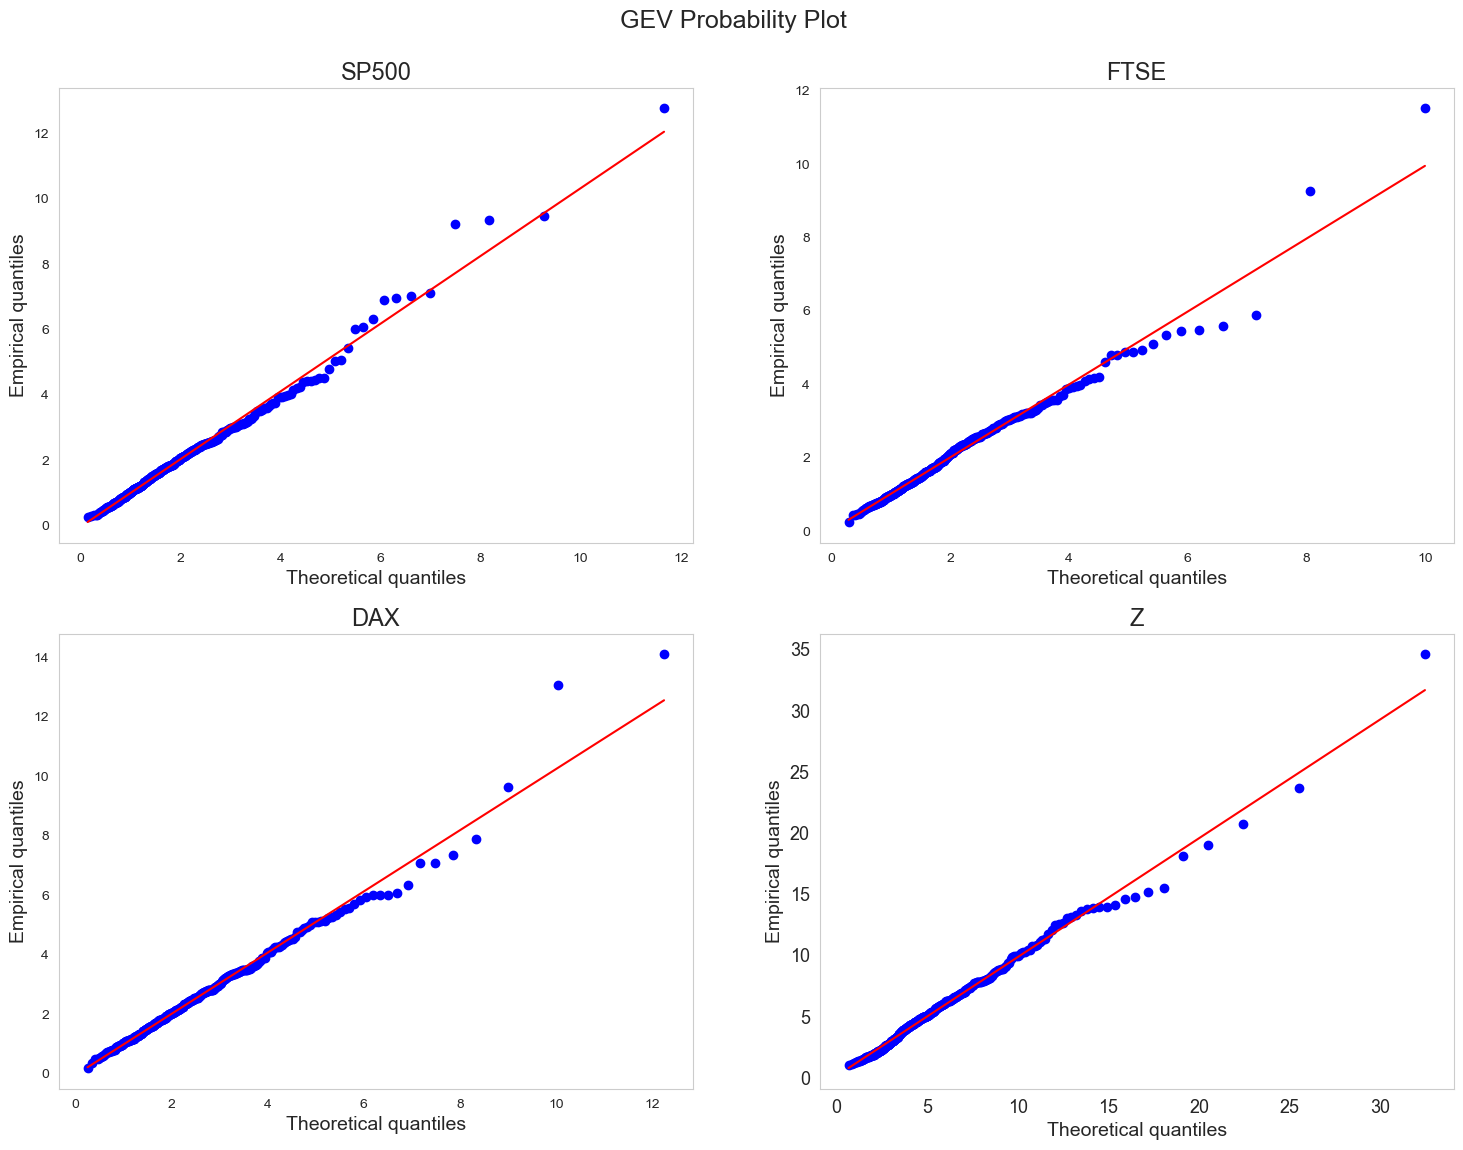

In [30]:
# GEV Probability plot for goodness of fit

fig, ax = plt.subplots(2, 2, figsize=(18, 13))

for a, stock_index in zip(ax.ravel(), store_param_block_max.columns):
    shape, loc, scale = store_param_block_max[stock_index]
    max_values = store_block_max[stock_index].values
    
    stats.probplot(max_values, dist=stats.genextreme(shape, loc, scale), plot=a)
    a.set_title(f'{stock_index}', fontsize=17)
    a.set_xlabel("Theoretical quantiles", fontsize=14)
    a.set_ylabel("Empirical quantiles", fontsize=14)
    a.grid(False)

    # Tick size
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)

plt.suptitle("GEV Probability Plot", fontsize=18, y=0.94)
plt.show()


## MEP

In [31]:
# Using K=sqrt(N)
K = np.sqrt(losses.shape[0]).astype(int)
N = losses.shape[0]

# DataFrame
MEP_store = pd.DataFrame(index=np.arange(K), columns=losses.columns)

for stock_index in losses.columns:
    stock_series = losses[stock_index].copy()
    stock_series_sorted = np.sort(stock_series).copy()
    subset = stock_series_sorted[-K:]
    
    MEP_store[stock_index] = subset
    
MEP_store    
    

,SP500,FTSE,DAX,Z
0,3.155252,3.046881,3.936120,8.845304
1,3.163586,3.056012,3.953098,8.869102
2,3.179613,3.078315,3.974526,8.874272
3,3.227979,3.088509,3.991296,8.891527
4,3.236924,3.098455,4.015714,8.965917
...,...,...,...,...
87,9.218959,7.428657,7.893107,20.743959
88,9.353652,7.998860,8.276975,22.306009
89,9.469512,8.178433,9.627704,23.611077
90,9.994485,9.264548,13.054859,24.176876


In [32]:

store_param_mep = pd.DataFrame(index=["shape", "loc", "scale"], columns=MEP_store.columns)

for stock_index in MEP_store.columns:
    shape, loc, scale = stats.genpareto.fit(MEP_store[stock_index].values)
    
    store_param_mep[stock_index] = [shape, loc, scale]
    
    # Shape parameter is inverted sign
    print(f"\n{stock_index} ->> Shape parameter: {shape}, Location parameter: {loc}, Scale parameter: {scale}")
    
print("")
store_param_mep


# !!! THE FITTED LOC PARAMETER IS OUR THRESHOLD, THAT IS THE FIRST ROW IN THE ABOVE DATASET
# (just a confusion because in the Reference Paper no Loc parameter is indicated, and this is because Loc=Threshold (with approximation errors))



SP500 ->> Shape parameter: 0.20298736018235203, Location parameter: 3.155251974124278, Scale parameter: 1.2075815212293182

FTSE ->> Shape parameter: 0.10895755388426304, Location parameter: 3.0468809622149795, Scale parameter: 0.9343947466549964

DAX ->> Shape parameter: 0.0749274692474748, Location parameter: 3.922154545716162, Scale parameter: 1.2147834036780578

Z ->> Shape parameter: 0.10572204077988734, Location parameter: 8.845304023079542, Scale parameter: 3.2079256435060395



,SP500,FTSE,DAX,Z
shape,0.202987,0.108958,0.074927,0.105722
loc,3.155252,3.046881,3.922155,8.845304
scale,1.207582,0.934395,1.214783,3.207926


In [33]:
# Compute quantile (VaR) from the fitted distribution

# same formula as before ???

var_mep = lambda shape, thresh, scale, alpha, N, K: thresh + scale/shape*((N/K * (1-alpha))**(-shape) - 1) if shape!=0 else thresh + scale*np.log(N/K * (1-alpha))


for stock_index in store_param_mep.columns:
    shape, loc, scale = store_param_mep[stock_index].values
    
    var_fit = var_mep(shape, loc, scale, alpha_var, N, K)
    var_store.loc[stock_index, "MEP"] = var_fit
    
print("")
var_store


,Block_max,MEP,Hill,QQ
SP500,3.547215,4.159781,NaN,NaN
FTSE,3.286998,3.796031,NaN,NaN
DAX,4.281637,4.883302,NaN,NaN
Z,9.569901,11.414014,NaN,NaN


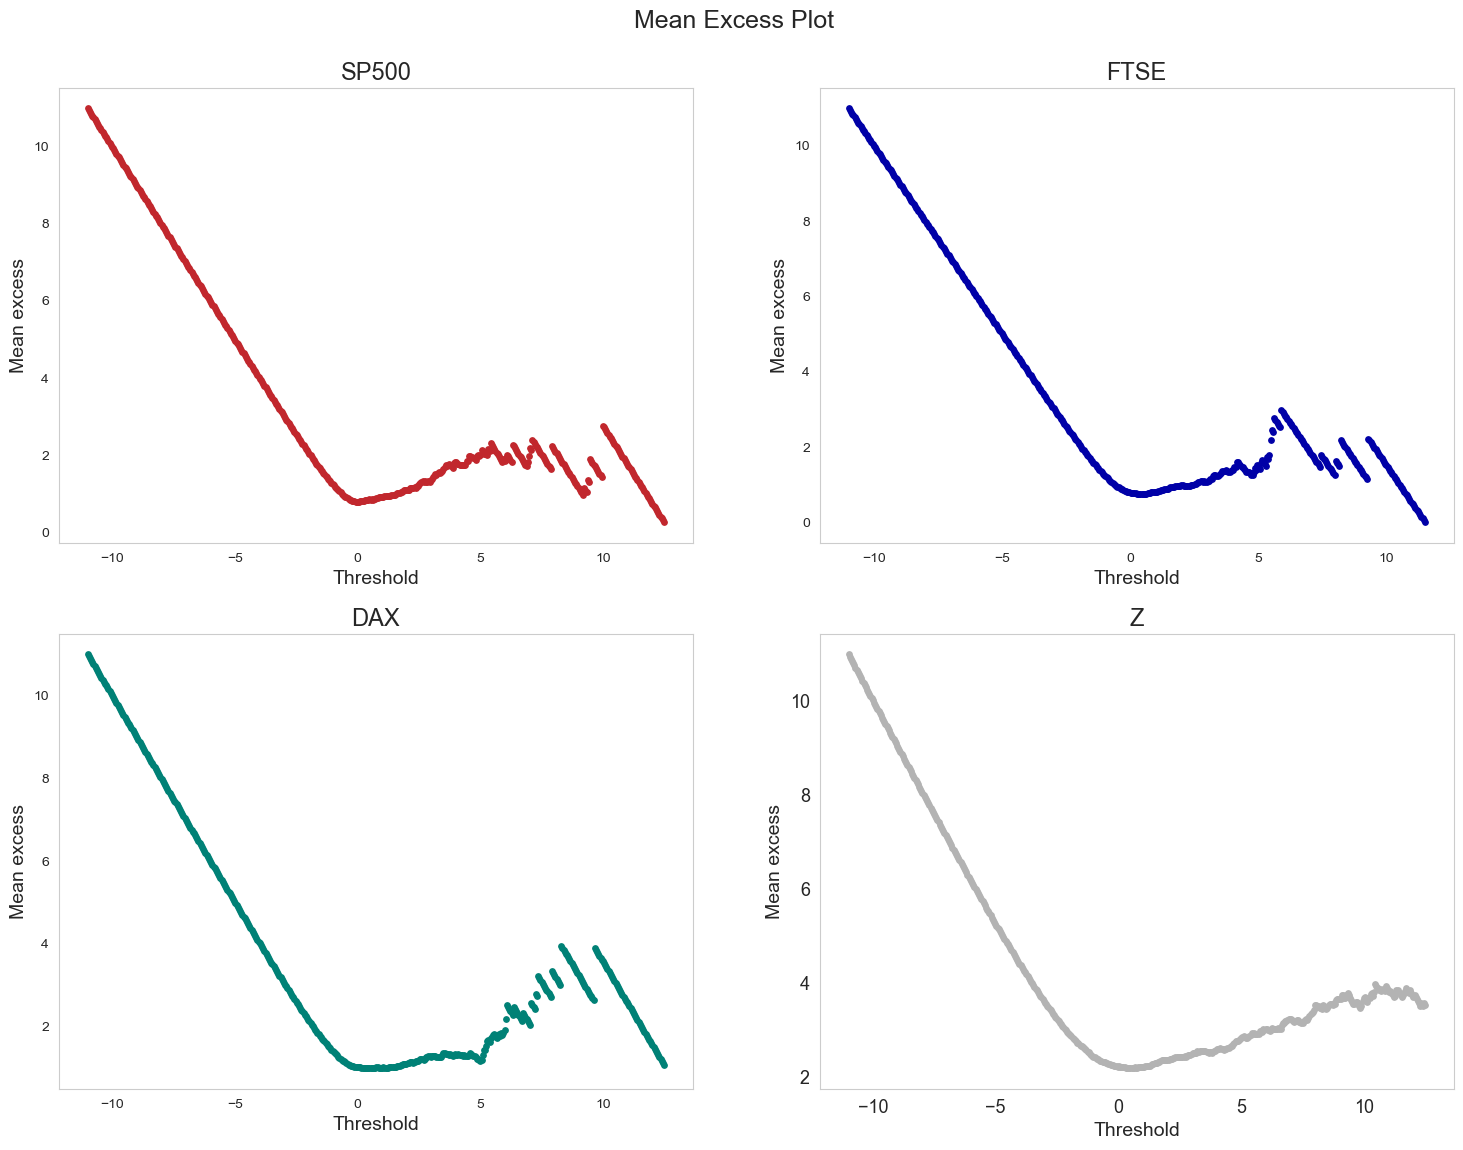

In [34]:
# Threshold selection

thresholds = np.linspace(-11, 12.5, num=500)

thresh_df = pd.DataFrame(index = np.arange(len(thresholds)))
thresh_df["thresholds"] = thresholds.tolist()

for stock_index in losses.columns:
    mean_excesses = []
    stock_series = losses[stock_index]

    for thresh in thresholds:
        excess = (stock_series[stock_series>thresh] - thresh).mean()
        mean_excesses.append(excess)
        
    thresh_df[stock_index] = mean_excesses
    
    
    
# Mean Excess Plot

fig, ax = plt.subplots(2,2, figsize=(18, 13))

for a, stock_idx, col in zip(ax.ravel(), thresh_df.columns[1:], ALL_COL):
    mean_excesses = thresh_df[stock_idx]
    a.scatter(thresholds, mean_excesses, s=15, color=col)
    a.set_title(f'{stock_idx}', fontsize=17)
    a.set_xlabel("Threshold", fontsize=14)
    a.set_ylabel("Mean excess", fontsize=14)
    a.grid(False)
    
    # Tick size
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    
plt.suptitle("Mean Excess Plot", fontsize=18, y=0.94)
plt.show()




## Hill

In [35]:
# Using K=sqrt(N)
K = np.sqrt(losses.shape[0]).astype(int)
N = losses.shape[0]

# DataFrame
Hill_store = pd.DataFrame(index=np.arange(K), columns=losses.columns)
Hill_thresh_store = pd.DataFrame(index=["thresholds"], columns=losses.columns)

for stock_index in losses.columns:
    stock_series = losses[stock_index].copy()
    stock_series_sorted = np.sort(stock_series).copy()
    subset = stock_series_sorted[-K:]
    
    Hill_store[stock_index] = subset
    Hill_thresh_store.loc["thresholds", stock_index] = stock_series_sorted[-K-1]   # take threshold equal to (k+1)th biggest value, since k biggest values are included
  
# Hill store is exactly equal to MEP_store, but we gathered thresholds on the way

Hill_store, Hill_thresh_store     
    

(        SP500       FTSE        DAX          Z
 0    3.155252   3.046881   3.936120   8.845304
 1    3.163586   3.056012   3.953098   8.869102
 2    3.179613   3.078315   3.974526   8.874272
 3    3.227979   3.088509   3.991296   8.891527
 4    3.236924   3.098455   4.015714   8.965917
 ..        ...        ...        ...        ...
 87   9.218959   7.428657   7.893107  20.743959
 88   9.353652   7.998860   8.276975  22.306009
 89   9.469512   8.178433   9.627704  23.611077
 90   9.994485   9.264548  13.054859  24.176876
 91  12.765220  11.511706  14.091166  34.561050
 
 [92 rows x 4 columns],
                SP500     FTSE       DAX         Z
 thresholds  3.150823  3.04657  3.934171  8.839039)

In [36]:

# Hill shape estimation (formula from https://link.springer.com/article/10.1007/s42519-020-00114-7, equivalent to slides)

Hill_shape_est = pd.DataFrame(columns=store_param_mep.columns, index=["shape"])

for stock_index in Hill_shape_est.columns:
    log_stock_series = np.log(Hill_store[stock_index])
    shape_est = log_stock_series.mean() - np.log(Hill_thresh_store.loc["thresholds", stock_index])
    Hill_shape_est.loc["shape", stock_index] = shape_est
    
store_param_Hill = store_param_mep.copy()   # we copy loc and scale from MEP + newly estimated shapes
store_param_Hill.loc["shape", :] = Hill_shape_est.loc["shape"]   # change to newly estimated shapes

#store_param_Hill.loc["loc", :] = [0]*4
#store_param_Hill.loc["scale", :] = [1]*4


store_param_Hill

,SP500,FTSE,DAX,Z
shape,0.337776,0.267783,0.258924,0.302082
loc,3.155252,3.046881,3.922155,8.845304
scale,1.207582,0.934395,1.214783,3.207926


In [37]:
# Compute quantile (VaR) from the fitted distribution


var_mep = lambda shape, thresh, scale, alpha, N, K: thresh + scale/shape*((N/K * (1-alpha))**(-shape) - 1) if shape!=0 else thresh + scale*np.log(N/K * (1-alpha))


for stock_index in store_param_Hill.columns:
    shape, loc, scale = store_param_Hill[stock_index].values
    
    var_fit = var_mep(shape, loc, scale, alpha_var, N, K)
    var_store.loc[stock_index, "Hill"] = var_fit
    
print("")
var_store


,Block_max,MEP,Hill,QQ
SP500,3.547215,4.159781,4.215088,NaN
FTSE,3.286998,3.796031,3.844357,NaN
DAX,4.281637,4.883302,4.95529,NaN
Z,9.569901,11.414014,11.620828,NaN


## QQ

In [38]:

# Hill shape estimation (formula from https://link.springer.com/article/10.1007/s42519-020-00114-7, equivalent to slides)

QQ_shape_est = pd.DataFrame(columns=store_param_mep.columns, index=["shape"])

range_k = np.arange(1, K+1)
denom = K * np.sum(  ( - np.log( range_k/K+1  ) )**2  ) - np.sum(- np.log(range_k/K+1)   )**2

for stock_index in QQ_shape_est.columns:
    stock_series = Hill_store[stock_index].values
    
    sec_num = (np.log(stock_series)).sum()
    num = 0
    
    for k in range(1, K+1):
        num += - np.log((k)/(K+1)) * (K * np.log(stock_series[-k]) - sec_num)       
        
    shape_est = num / denom
    QQ_shape_est.loc["shape", stock_index] = shape_est
    
store_param_QQ = store_param_mep.copy()   # we copy loc and scale from MEP + newly estimated shapes
store_param_QQ.loc["shape", :] = QQ_shape_est.loc["shape"]   # change to newly estimated shapes

store_param_QQ.loc["loc", :] = [0]*4
store_param_QQ.loc["scale", :] = [1]*4

store_param_QQ

,SP500,FTSE,DAX,Z
shape,7.209406,6.211367,5.393342,6.14851
loc,0.000000,0.000000,0.000000,0.00000
scale,1.000000,1.000000,1.000000,1.00000


In [39]:
# Compute quantile (VaR) from the fitted distribution


var_mep = lambda shape, thresh, scale, alpha, N, K: thresh + scale/shape*((N/K * (1-alpha))**(-shape) - 1) if shape!=0 else thresh + scale*np.log(N/K * (1-alpha))


for stock_index in store_param_QQ.columns:
    shape, loc, scale = store_param_QQ[stock_index].values
    
    var_fit = var_mep(shape, loc, scale, alpha_var, N, K)
    var_store.loc[stock_index, "QQ"] = var_fit
    
print("")
var_store



,Block_max,MEP,Hill,QQ
SP500,3.547215,4.159781,4.215088,35.238957
FTSE,3.286998,3.796031,3.844357,18.905819
DAX,4.281637,4.883302,4.95529,11.524021
Z,9.569901,11.414014,11.620828,18.190598


In [40]:
risk_measures.T

,VAR_empirical,tVAR_empirical
SP500,4.144687,4.759571
FTSE,3.709643,4.220542
DAX,5.053964,5.349617
Z,11.467759,12.673033


## III. Bivariate analyis

### Draw the ranked scatter plot for the three pairs, do you see a difference?

In [41]:
ftse = losses["FTSE"]
dax = losses["DAX"]
sp500 = losses["SP500"]


def plot_rankscatter(series1, series2, ax, title = None):
    ranks1 = stats.rankdata(series1)
    ranks2 = stats.rankdata(series2)

    ax.scatter(ranks1, ranks2, s = 2, color = DARK_COL)
    ax.grid(False)
    ax.set_xlabel(series1.name)
    ax.set_ylabel(series2.name)
    ax.set_title(title)

def plot_rankscatters():
    fig, axs = plt.subplots(ncols=3, figsize = (20, 6))
    for i, (x, y) in enumerate(combinations([ftse, dax, sp500], r = 2)):
        ranks_x = stats.rankdata(x)
        ranks_y = stats.rankdata(y)
        cor_spearman = stats.spearmanr(x, y)
        axs[i].scatter(ranks_x, ranks_y, s = 2, color = DARK_COL)
        axs[i].grid(False)
        axs[i].set_xlabel(x.name)
        axs[i].set_ylabel(y.name)
        axs[i].set_title(f"{x.name} & {y.name} (Spearman: {cor_spearman.statistic: .2f})")
    plt.show()

In [42]:
#plot_rankscatter(ftse, dax)

In [43]:
#plot_rankscatter(ftse, sp500)

In [44]:
#plot_rankscatter(sp500, dax)

### Compute the Spearman and the Pearson correlation, what do you obtain?

In [45]:
# Spearman and Pearson coefficients
def get_correlations(*series_list):
    # Get all combinations of 2 elements in series_list
    combs = combinations(list(series_list), r = 2)
    res = pd.DataFrame(np.zeros((len(list(series_list)), 2)), columns=["Spearman", "Pearson"])
    # Get the names of the elements for indexing the final dataframe
    combs_names = combinations(list(series_list), r = 2)
    combs_names = [(x.name, y.name) for x, y in list(combs_names)]
    res = res.reindex(combs_names)
    # Compute correlations for every combination
    for i, (x, y) in enumerate(combs):
        cor_spearman = stats.spearmanr(x, y)
        cor_pearson = stats.pearsonr(x, y)
        res.iloc[i] = [cor_spearman.statistic, cor_pearson.statistic]
    return res

In [46]:
np.corrcoef(np.array([sp500, dax, ftse]))

array([[1.        , 0.53072267, 0.51097447],
       [0.53072267, 1.        , 0.75963381],
       [0.51097447, 0.75963381, 1.        ]])

In [47]:
def get_correlations(*series_list):
    names = [x.name for x in list(series_list)]
    print("Spearman correlation")
    corrs_spearman = stats.spearmanr(np.array([sp500, dax, ftse]).transpose()).statistic
    df_corrs_spearman = pd.DataFrame(corrs_spearman, columns = names, index = names)
    print(df_corrs_spearman)
    
    print("-----------------------------------")
    print("Pearson correlation")
    corrs_pearson = np.corrcoef(np.array([sp500, dax, ftse]))
    df_corrs_pearson = pd.DataFrame(corrs_pearson, columns = names, index = names)
    print(df_corrs_pearson)
    return df_corrs_spearman, df_corrs_pearson

In [48]:
df_corrs_spearman, df_corrs_pearson = get_correlations(sp500, dax, ftse)

Spearman correlation
          SP500       DAX      FTSE
SP500  1.000000  0.454614  0.438644
DAX    0.454614  1.000000  0.708778
FTSE   0.438644  0.708778  1.000000
-----------------------------------
Pearson correlation
          SP500       DAX      FTSE
SP500  1.000000  0.530723  0.510974
DAX    0.530723  1.000000  0.759634
FTSE   0.510974  0.759634  1.000000


### Suggest copulas to model dependence and fit them to your data

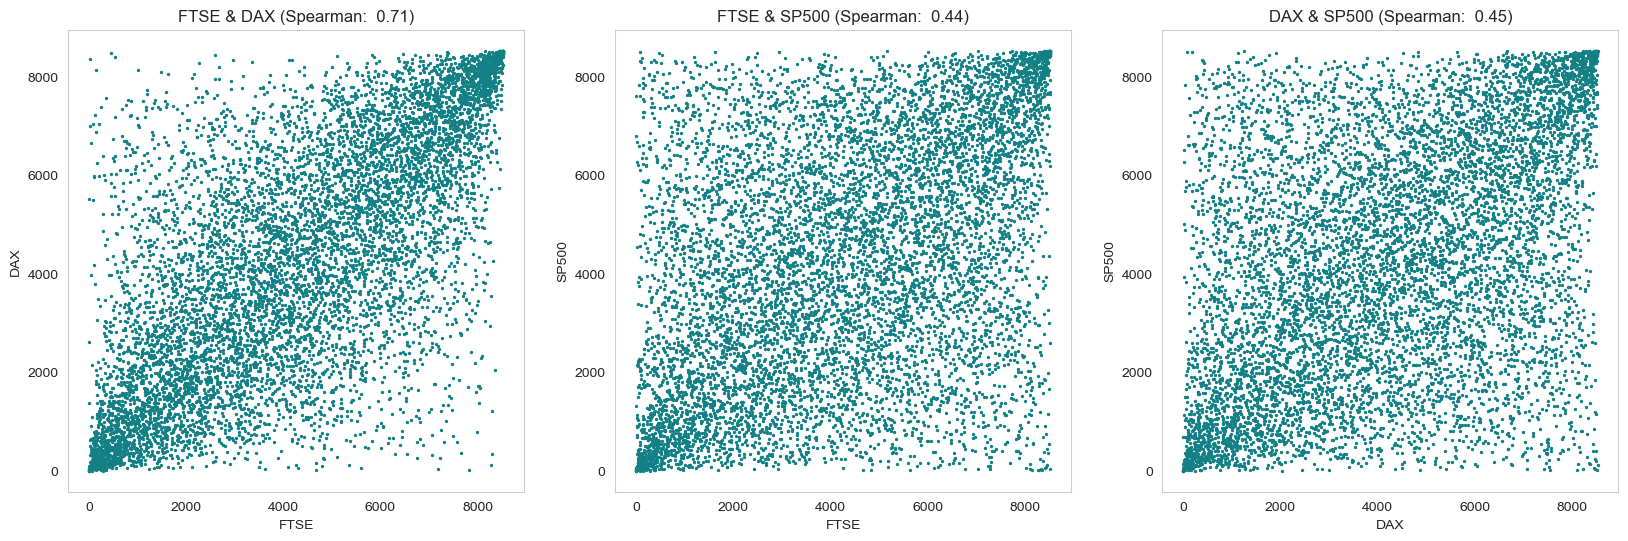

In [49]:
plot_rankscatters()

Available choices: *Clayton, survival Clayton, Gumbel, Student, Gaussian*\
\
Clayton, survival clayton always can be ruled out (dependence on both sides).
1. FTSE & DAX: **Student-t** (off-diagonal elements in matrix around 0.8, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), some outliers in top-left and bottom-right corners (no Gauss)
2. FTSE & S&P 500: **Student-t** (off-diagonal elements in matrix around 0.5-0.6, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), a lot of outliers in top-left and bottom-right corners (no Gauss)
3. DAX & S&P 500: **Student-t** (off-diagonal elements in matrix around 0.5-0.6, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), a lot of outliers in top-left and bottom-right corners (no Gauss)


In [50]:
def plot_copula(ax_plot, ax_none, rho = 0.8, deg_freedom = 4):
    R1 = np.full((2,2), rho)
    np.fill_diagonal(R1, 1)
    student_copula = StudentTCopula(R1, deg_freedom)
    sample = student_copula.plot_scatter(nobs = len(dax), ax = ax_none)
    fig.delaxes(ax_none)
    x, y = sample[1].transpose()
    ax_plot.scatter(x, y, s = 2, color = DARK_COL)
    ax_plot.grid(False)
    ax_plot.set_title(f"Copula (corr: {student_copula.corr[1][0]: .4f}), deg. of freedom: {student_copula.df}")

In [51]:
# Export to csv
losses.to_csv("./data/losses.csv")

#### FTSE & DAX: Student copula
- rho: 0.7418422 
- df: 4.0000000 

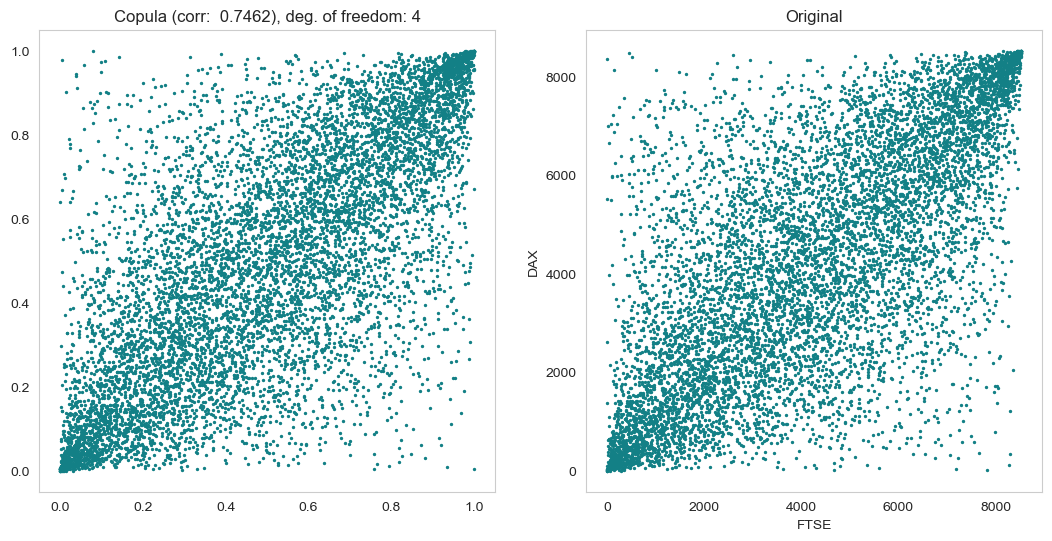

In [52]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
plot_copula(axs[0], axs[2], rho = 0.7461536, deg_freedom=4)
plot_rankscatter(ftse, dax, axs[1], title = "Original")

#### FTSE & S&P 500: Student copula
- rho: 0.4708334
- df: 4.0000000 

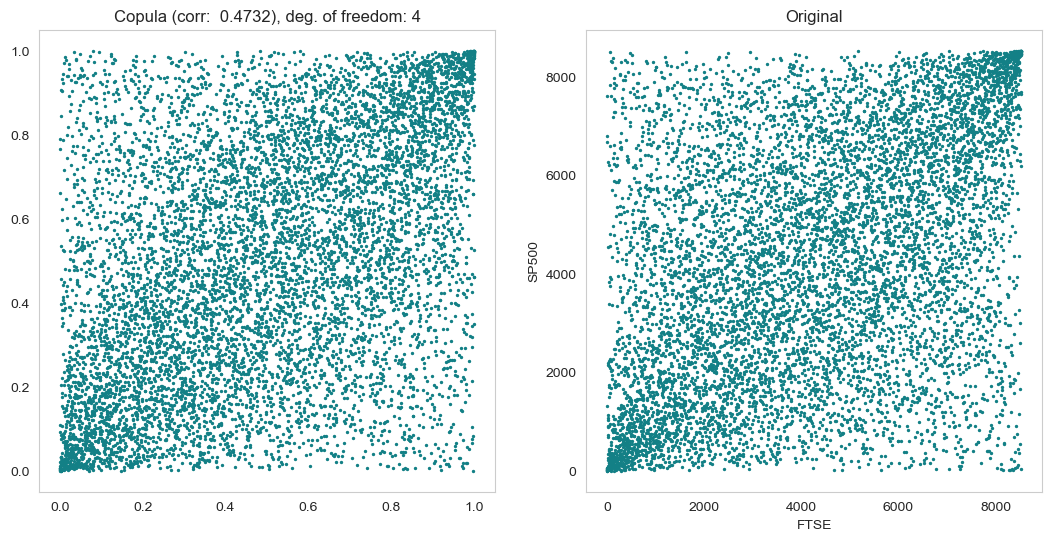

In [53]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
plot_copula(axs[0], axs[2], rho = 0.473188, deg_freedom=4)
plot_rankscatter(ftse, sp500, axs[1], title = "Original")

#### DAX & S&P 500: Student copula
- rho: 0.4881037
- df: 4.0000000 

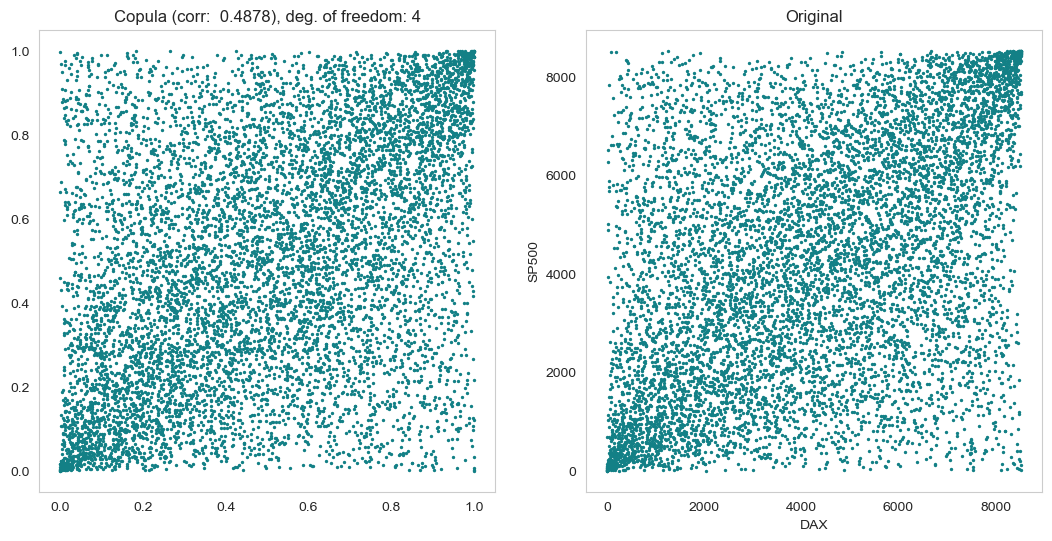

In [54]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
plot_copula(axs[0], axs[2], rho = 0.4878477, deg_freedom=4)
plot_rankscatter(dax, sp500, axs[1], title = "Original")